In [1]:
#[Joe] 1. Acquire and process stock data
#[Alejandra]x 2. Acquire and process sentiment analysis data
#[Session] 3. Run baseline
#[Joe]x 4. Run sentiment analysis with LinearDiscreminateAnalysis
#[Edward] 5. Run sentiment analysis with alternate classifier
#[Edward] 6. Combine results
#[Session] 7. Put together PPT preso

In [66]:
import pandas as pd
import numpy as np
from pathlib import Path
from textblob import TextBlob
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import yfinance as yf
import warnings
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Ignore all warnings within this code block
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [30]:
## Acquire and process sentiment data from Kaggle
sentiment_df=pd.read_csv(Path("../Resources/combined_csv.csv"))
sentiment_df.head()

,Time,Headline,SP500 Close,Volume,TSLA Close,Volume.1
0,2017-12-18,Brace yourself for the next Brexit faultline: ...,268.200012,83653600.0,22.591333,82143000.0
1,2017-12-19,"First pilots, now cabin crew – Ryanair to reco...",267.170013,82382900.0,22.073334,102375000.0
2,2017-12-20,"Nearly 45,000 UK retailers in financial distre...",267.029999,76751500.0,21.931999,89307000.0
3,2017-12-21,Last-minute Christmas shopping guide: there is...,267.579987,67032300.0,22.110666,65778000.0
4,2017-12-22,Cramer: Never buy a stock all at once — you'll...,267.510010,78720900.0,21.680000,63237000.0


In [31]:
# obtain polarity and subjectivity scores (potentially factor volume of information in the sentiment analysis)

# create a function to calculate the subjectivity
def calculate_subjectivity(headlines):
    return TextBlob(headlines).sentiment.subjectivity

# create a function to calculate the subjectivity
def calculate_polarity(headlines):
    return TextBlob(headlines).sentiment.polarity


In [32]:
# create two new columns "Subjectivity" and "Polarity"
sentiment_df["Subjectivity"] = sentiment_df["Headline"].apply(calculate_subjectivity)
sentiment_df["Polarity"] = sentiment_df["Headline"].apply(calculate_polarity)

In [33]:
# create function to get the sentiment scores 
def get_scores(headlines):
    get_score= SentimentIntensityAnalyzer()
    sentiment=get_score.polarity_scores(headlines)
    return sentiment

In [34]:
# get daily sentiment scores
compound = []
neg = []
pos = []
neu = []
score = 0

for x in range(0, len(sentiment_df["Headline"])):
    score = get_scores(sentiment_df["Headline"][x])
    compound.append(score["compound"])
    neg.append(score["neg"])
    neu.append(score["neu"])
    pos.append(score["pos"])
    

In [35]:
# Add Column with sentiment scores
sentiment_df["compound"]= compound
sentiment_df["neg"]= neg
sentiment_df["pos"]= pos
sentiment_df["neu"]= neu

# Assuming you have a DataFrame named 'sentiment_df'
sentiment_df.rename(columns={'Volume.1': 'Tvolume'}, inplace=True)

#Display Dataframe
sentiment_df.head()


,Time,Headline,SP500 Close,Volume,TSLA Close,Tvolume,Subjectivity,Polarity,compound,neg,pos,neu
0,2017-12-18,Brace yourself for the next Brexit faultline: ...,268.200012,83653600.0,22.591333,82143000.0,0.349438,-0.000624,-0.9425,0.122,0.075,0.804
1,2017-12-19,"First pilots, now cabin crew – Ryanair to reco...",267.170013,82382900.0,22.073334,102375000.0,0.303711,-0.043869,-0.9760,0.127,0.027,0.846
2,2017-12-20,"Nearly 45,000 UK retailers in financial distre...",267.029999,76751500.0,21.931999,89307000.0,0.405042,-0.020270,-0.8761,0.104,0.077,0.818
3,2017-12-21,Last-minute Christmas shopping guide: there is...,267.579987,67032300.0,22.110666,65778000.0,0.522302,-0.036371,0.4404,0.094,0.113,0.793
4,2017-12-22,Cramer: Never buy a stock all at once — you'll...,267.510010,78720900.0,21.680000,63237000.0,0.429320,0.038917,-0.2362,0.096,0.108,0.797


In [36]:
# Calculate daily returns 
sentiment_df["daily returns"]= sentiment_df["TSLA Close"].pct_change()

# Drop SP500 Columns 
sentiment_df.drop(columns=["SP500 Close", "Volume"], inplace = True)

# Set Time to be the index and convert to date time format
sentiment_df= sentiment_df.set_index("Time")
sentiment_df.index= pd.to_datetime(sentiment_df.index)

In [10]:
# Calculations for model with SP500 
# Calculate daily returns 
# sentiment_df["daily returns"]= sentiment_df["SP500 Close"].pct_change()
# sentiment_df.drop(columns=["TSLA Close", "Tvolume"], inplace = True)
# sentiment_df= sentiment_df.set_index("Time")
# sentiment_df.index= pd.to_datetime(sentiment_df.index)

In [11]:
# create label column add 1 when daily returns is positive and 0 when it is negative
# sentiment_df["label"]= 0
# sentiment_df.loc[(sentiment_df["daily returns"]> 0), 'label'] = 1

# # verify that label is int
# sentiment_df["label"].dtype

In [37]:
# # calculate SMA short and SMA slow
sentiment_df["sma_short"]= sentiment_df.rolling(7)["TSLA Close"].mean()
sentiment_df["sma_long"]= sentiment_df.rolling(60)["TSLA Close"].mean()
sentiment_df.dropna(inplace=True)

In [13]:
# calculate SMA short and SMA slow
# sentiment_df["sma_short"]= sentiment_df.rolling(7)["SP500 Close"].mean()
# sentiment_df["sma_long"]= sentiment_df.rolling(30)["SP500 Close"].mean()
# sentiment_df.dropna(inplace=True)

In [38]:
# display dataframe
sentiment_df.columns

Index(['Headline', 'TSLA Close', 'Tvolume', 'Subjectivity', 'Polarity',
       'compound', 'neg', 'pos', 'neu', 'daily returns', 'sma_short',
       'sma_long'],
      dtype='object')

In [39]:
# create features variable with columns for X
#TSLA Version
features=['Tvolume', 'Subjectivity', 'Polarity',
       'compound', 'neg', 'pos', 'neu', 'sma_short',
       'sma_long']

X = sentiment_df[features].shift().dropna().copy()
X.tail()

#SP500 Version
# create features variable with columns for X
# features=['Volume', 'Subjectivity', 'Polarity',
#        'compound', 'neg', 'pos', 'neu', 'sma_short',
#        'sma_long']

# X = sentiment_df[features].shift().dropna().copy()
# X.tail()

,Tvolume,Subjectivity,Polarity,compound,neg,pos,neu,sma_short,sma_long
Time,,,,,,,,,
2020-07-13,350064000.0,0.368474,0.074615,-0.4037,0.100,0.103,0.797,89.471810,60.918122
2020-07-14,584781000.0,0.414809,0.140556,0.9773,0.100,0.123,0.777,93.066382,61.753511
2020-07-15,351271500.0,0.345320,0.057631,-0.9830,0.104,0.082,0.814,96.001050,62.601189
2020-07-16,245517000.0,0.387709,0.012013,0.5514,0.127,0.128,0.745,97.662287,63.489689
2020-07-17,214512000.0,0.393206,0.088800,-0.9979,0.141,0.088,0.771,98.717334,64.394044


In [40]:
# create labels for y value using daily returns
y=(sentiment_df['daily returns']>0).astype(int)[1:]

In [41]:
# verify x and y are same length
display(len(X))
display(len(y))

587

587

In [75]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

2018-03-20 00:00:00
2018-06-20 00:00:00


,Tvolume,Subjectivity,Polarity,compound,neg,pos,neu,sma_short,sma_long
Time,,,,,,,,,
2018-03-20,112264500.0,0.396209,0.040144,-0.3551,0.118,0.111,0.771,21.920571,22.285689
2018-03-21,71464500.0,0.374032,0.028472,-0.9856,0.117,0.082,0.801,21.762286,22.254222
2018-03-22,89376000.0,0.377280,0.073502,-0.9679,0.109,0.091,0.800,21.486285,22.238033
2018-03-23,74097000.0,0.364351,0.060998,0.4632,0.129,0.124,0.747,21.174476,22.215944
2018-03-26,99823500.0,0.410239,0.051506,-0.9812,0.107,0.080,0.813,20.935523,22.182478


In [44]:
## Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [45]:
## Use a classifier to predict future results

# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

           0       0.57      0.13      0.21       254
           1       0.52      0.91      0.66       268

    accuracy                           0.53       522
   macro avg       0.55      0.52      0.44       522
weighted avg       0.55      0.53      0.44       522



In [57]:
# Create a predictions DataFrame
predictions_sentiment_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_sentiment_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_sentiment_df['Actual Returns'] = sentiment_df['daily returns']

# Add the strategy returns to the DataFrame
predictions_sentiment_df['Strategy Returns'] = predictions_sentiment_df['Actual Returns'] * predictions_sentiment_df['Predicted']

# Review the DataFrame
display(predictions_sentiment_df.head())
display(predictions_sentiment_df.tail())


,Predicted,Actual Returns,Strategy Returns
Time,,,
2018-06-21,1,-0.040611,-0.040611
2018-06-22,1,-0.039941,-0.039941
2018-06-25,1,-0.001858,-0.001858
2018-06-26,1,0.026996,0.026996
2018-06-27,1,0.007310,0.007310


,Predicted,Actual Returns,Strategy Returns
Time,,,
2020-07-13,1,-0.030810,-0.030810
2020-07-14,1,0.013186,0.013186
2020-07-15,1,0.019258,0.019258
2020-07-16,1,-0.029347,-0.029347
2020-07-17,1,0.000133,0.000133


In [55]:
# count predictions values and test values
print("Predictions value counts:")
print(f"{predictions_sentiment_df['Predicted'].value_counts()}")
print("Y test value counts:")
print(f"{y_test.value_counts()}")

Predictions value counts:
1    464
0     58
Name: Predicted, dtype: int64
Y test value counts:
1    268
0    254
Name: daily returns, dtype: int64


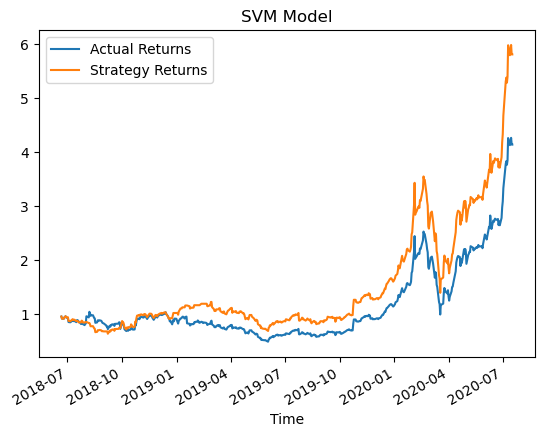

In [68]:
# plot cumulative returns
plot_cum_returns= (1 + predictions_sentiment_df[["Actual Returns", "Strategy Returns"]]).cumprod()
plot_cum_returns.plot(title='SVM Model')

# Save the plot as a png file
plt.savefig('../Resources/SVC.png', format='png')

# Save the plot as a JPG file
# plt.savefig('SP500_SVM.jpg', format='jpg')


In [76]:
# instantiate LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()


In [77]:
# Fit the model to the data using the training data
linear_disc_model = model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
linear_disc_model = model.predict(X_test_scaled)

# Review the model's predicted values
linear_disc_model[:10]

# Use a classification report to evaluate the model using the predictions and testing data
linear_disc_testing_report = classification_report(y_test, linear_disc_model)

# Print the classification report
print(linear_disc_testing_report)


              precision    recall  f1-score   support

           0       0.47      0.43      0.45       254
           1       0.50      0.53      0.51       268

    accuracy                           0.48       522
   macro avg       0.48      0.48      0.48       522
weighted avg       0.48      0.48      0.48       522



In [78]:
predictions_sentiment_df_2 = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_sentiment_df_2['Predicted'] = linear_disc_model

# Add the actual returns to the DataFrame
predictions_sentiment_df_2['Actual Returns'] = sentiment_df['daily returns']

# Add the strategy returns to the DataFrame
predictions_sentiment_df_2['Strategy Returns'] = predictions_sentiment_df_2['Actual Returns'] * predictions_sentiment_df_2['Predicted']

# Review the DataFrame
display(predictions_sentiment_df_2.head())
display(predictions_sentiment_df_2.tail())


,Predicted,Actual Returns,Strategy Returns
Time,,,
2018-06-21,1,-0.040611,-0.040611
2018-06-22,1,-0.039941,-0.039941
2018-06-25,1,-0.001858,-0.001858
2018-06-26,1,0.026996,0.026996
2018-06-27,0,0.007310,0.000000


,Predicted,Actual Returns,Strategy Returns
Time,,,
2020-07-13,0,-0.030810,-0.0
2020-07-14,0,0.013186,0.0
2020-07-15,0,0.019258,0.0
2020-07-16,0,-0.029347,-0.0
2020-07-17,0,0.000133,0.0


In [79]:
# count predictions values and test values
print("Predictions value counts:")
print(f"{predictions_sentiment_df_2['Predicted'].value_counts()}")
print("Y test value counts:")
print(f"{y_test.value_counts()}")

Predictions value counts:
1    286
0    236
Name: Predicted, dtype: int64
Y test value counts:
1    268
0    254
Name: daily returns, dtype: int64


<Axes: title={'center': 'Linear Discriminant Analysis Model'}, xlabel='Time'>

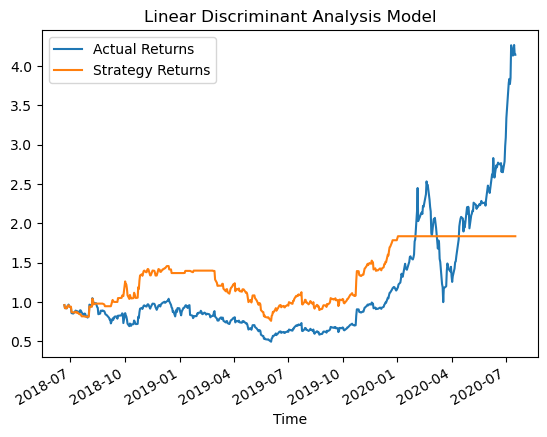

In [80]:
# plot cumulative returns
plot_cum_returns= (1 + predictions_sentiment_df_2[["Actual Returns", "Strategy Returns"]]).cumprod()
plot_cum_returns.plot(title='Linear Discriminant Analysis Model')

# Save the plot as a png file
# plt.savefig('../Resources/SVC.png', format='png')

# predictions_sentiment_df_2[["Actual Returns","Strategy Returns"]].plot()
# # plt.savefig('SP500 LinearDiscriminantAnalysis.jpg', format='jpg')
# plt.savefig('TSLA LinearDiscriminantAnalysis.jpg', format='jpg')
